In [1]:
#!/usr/bin/python3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
# import tensorflow as tf
# from sklearn.model_selection import train_test_split


# %matplotlib notebook

In [2]:
# ================= CONSTANTS =================
PMT_PULSE_LENGTH = 1500  # Sample lenght of a typical pulse
SAMPLES_BEFORE_PEAK = 4  # Samples to store before peak detection. MUST BE SMALLER THAN 8

In [3]:
# df=pd.read_csv("../data_Cs137/20210715_173047/20210715_173047_0.csv", index_col=0)
df=pd.read_csv("/mnt/hdd500/cernbox/Cs137_v4_t100_s65534_hv2000/20210825_split/20210825_150516/Cs137_v4_t100_joined.csv", index_col=0)

In [4]:
df

0    1    2    3    4    5    6    7    8    9  ...  5872  5873  \
0      137  137  137  137  137  137  101  137  137  137  ...   137   137   
1      137  138  137  138  137  137   98  137  137  138  ...   138   137   
2      137  137  137  137  137  138   89  137  137  137  ...   137   137   
3      138  138  137  138  137  138   90  137  137  138  ...   137   138   
4      137  137  137  137  137  137  107  138  137  137  ...   137   138   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
65529  138  137  137  137  137  138  137  137  137  137  ...   137   137   
65530  137  137  137  138  137  137  138  137  137  137  ...   138   138   
65531  138  137  138  137  137  137  137  137  137  137  ...   137   137   
65532  137  137  137  137  137  137  138  138  137  137  ...   137   137   
65533  137  137  137  138  137  137  137  137  138  138  ...   137   137   

       5874  5875  5876  5877  5878  5879  5880  5881  
0       138   137   137   138   137   137   138   137  
1       138   137   138   138   137   137   138   137  
2       137   137   137   137   137   137   137   137  
3       136   138   137   137   137   138   138   137  
4       134   138   137   137   137   137   138   137  
...     ...   ...   ...   ...   ...   ...   ...   ...  
65529   128   137   137   137   137   137   133   137  
65530   129   136   138   137   138   138   135   137  
65531   131   137   138   137   137   138   136   137  
65532   128   138   137   137   136   137   133   137  
65533   110   138   137   138   136   138   134   135  

[65534 rows x 5882 columns]

# Peak detection

In [5]:
def pkdetect(x, thr=100, pkh=10):
    peak=[]
    lmax=0
    imax=0
    count=0
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lmax:
            imax=i
            lmax=x[i]
        elif ((lmax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peak.append(imax)
            lmax=0
        else:
            pass
            
    return peak

# Individual pulse isolation and area estimation

In [6]:
#Isolating individual pulses within a trace

def isolatePulses(singleTrace, peakIndexesList, pulseLength, samplesBeforePeak):
    singleTrace = singleTrace.tolist()
    i = 0 #Input pulse index
    outputPulseIndex = 0
    diffFromLastPeak = pulseLength #In order to classify the first pulse as a valid event
    isolatedPulses = [] #Output variable (list of pulse samples) that stores each valid pulse
    
    #Be sure to slide along the whole trace, avoiding short pulses located at the end
    while ((i < len(peakIndexesList)) and (peakIndexesList[i] <= len(singleTrace) - pulseLength)):
        #print("Diff from last peak: " + str(diffFromLastPeak))
        if(diffFromLastPeak >= pulseLength):
            lowerPulseRange = peakIndexesList[i] - samplesBeforePeak #Be sure to record some samples before peak
            upperPulseRange = lowerPulseRange + pulseLength #Store the whole pulse
            isolatedPulses.append([])
            isolatedPulses[outputPulseIndex].extend(singleTrace[lowerPulseRange:upperPulseRange])
            #print("OutputPulseIndex: " + str(outputPulseIndex))
            outputPulseIndex += 1
            diffFromLastPeak = 0
        i += 1
        if i < len(peakIndexesList):
            diffFromLastPeak += peakIndexesList[i] - peakIndexesList[i-1] #Check if peaks are distant enough
            
        else:
            break
    
    return isolatedPulses
        

In [7]:
#Isolating individual pulses within a trace using multithreading

def isolatePulsesMP(singleTrace, peakIndexesList, pulseLength, samplesBeforePeak, queue):
    singleTrace = singleTrace.tolist()
    i = 0 #Input pulse index
    outputPulseIndex = 0
    diffFromLastPeak = pulseLength #In order to classify the first pulse as a valid event
    isolatedPulses = [] #Output variable (list of pulse samples) that stores each valid pulse
    
    
    #Be sure to slide along the whole trace, avoiding short pulses located at the end
    while ((i < len(peakIndexesList)) and (peakIndexesList[i] <= len(singleTrace) - pulseLength)):
        #print("Diff from last peak: " + str(diffFromLastPeak))
        if(diffFromLastPeak >= pulseLength):
            lowerPulseRange = peakIndexesList[i] - samplesBeforePeak #Be sure to record some samples before peak
            upperPulseRange = lowerPulseRange + pulseLength #Store the whole pulse
            isolatedPulses.append([])
            isolatedPulses[outputPulseIndex].extend(singleTrace[lowerPulseRange:upperPulseRange])            
            #print("OutputPulseIndex: " + str(outputPulseIndex))
            outputPulseIndex += 1
            diffFromLastPeak = 0
        i += 1
        if i < len(peakIndexesList):
            diffFromLastPeak += peakIndexesList[i] - peakIndexesList[i-1] #Check if peaks are distant enough
            
        else:
            break
        
    queue.put(isolatedPulses[1:])
        

In [8]:
#Dataframe with individual pulses
dfPulses = pd.DataFrame(columns = [0])

In [9]:
df[df.columns[1]]

0        137
1        138
2        137
3        138
4        137
        ... 
65529    137
65530    137
65531    137
65532    137
65533    137
Name: 1, Length: 65534, dtype: int64

In [10]:
import multiprocessing as mp

THREADS = 24




mpQueues = [mp.Queue() for i in range(THREADS)]
nTraces = len(df.T)
# nTraces = 9
traceIdx = 0



# for i in range(0, nTraces, THREADS):
#     runningThreads = 0
#     for j in range(THREADS):
#         currentTraceIndex = i + j
#         if currentTraceIndex < nTraces:
#             runningThreads += 1
#             thisTrace = df[df.columns[currentTraceIndex]]
#             peaksList = pkdetect(thisTrace, 10, 10)
#             p = mp.Process(target = isolatePulsesMP, args = (thisTrace, peaksList, PMT_PULSE_LENGTH, SAMPLES_BEFORE_PEAK, mpQueues[j]))
#             p.start()
#             print("Processing trace " + str(currentTraceIndex + 1) + "/" + str(nTraces))
#     for k in range(runningThreads):
# #         print("Joining thread " + str(k+1) + "/" + str(runningThreads))
#         testList = []
#         testList.extend(mpQueues[k].get())
#         testList = pd.Series(testList)
#         for l in testList:
#             dfPulses[traceIdx] = l
#             traceIdx += 1
#         p.join()
        
# print("Done!")
        




for i in range(nTraces):
#     testList.append([])
    thisTrace = df[df.columns[i]]
    peaksList = pkdetect(thisTrace, 10, 10)
    individualPulses = isolatePulses(thisTrace, peaksList, PMT_PULSE_LENGTH, SAMPLES_BEFORE_PEAK)[1:]
    #print("Individual pulses: " + str(individualPulses))
    print("Processing trace " + str(i + 1) + "/" + str(nTraces))
    for j in individualPulses:
        #print("j: " + str(j))
        dfPulses[traceIdx] = j
        traceIdx += 1
print("Done!")

Processing trace 1/5882
Processing trace 2/5882
Processing trace 3/5882
Processing trace 4/5882
Processing trace 5/5882
Processing trace 6/5882
Processing trace 7/5882
Processing trace 8/5882
Processing trace 9/5882
Processing trace 10/5882
Processing trace 11/5882
Processing trace 12/5882
Processing trace 13/5882
Processing trace 14/5882
Processing trace 15/5882
Processing trace 16/5882
Processing trace 17/5882
Processing trace 18/5882
Processing trace 19/5882
Processing trace 20/5882
Processing trace 21/5882
Processing trace 22/5882
Processing trace 23/5882
Processing trace 24/5882
Processing trace 25/5882
Processing trace 26/5882
Processing trace 27/5882
Processing trace 28/5882
Processing trace 29/5882
Processing trace 30/5882
Processing trace 31/5882
Processing trace 32/5882
Processing trace 33/5882
Processing trace 34/5882
Processing trace 35/5882
Processing trace 36/5882
Processing trace 37/5882
Processing trace 38/5882
Processing trace 39/5882
Processing trace 40/5882
Processin

Processing trace 321/5882
Processing trace 322/5882
Processing trace 323/5882
Processing trace 324/5882
Processing trace 325/5882
Processing trace 326/5882
Processing trace 327/5882
Processing trace 328/5882
Processing trace 329/5882
Processing trace 330/5882
Processing trace 331/5882
Processing trace 332/5882
Processing trace 333/5882
Processing trace 334/5882
Processing trace 335/5882
Processing trace 336/5882
Processing trace 337/5882
Processing trace 338/5882
Processing trace 339/5882
Processing trace 340/5882
Processing trace 341/5882
Processing trace 342/5882
Processing trace 343/5882
Processing trace 344/5882
Processing trace 345/5882
Processing trace 346/5882
Processing trace 347/5882
Processing trace 348/5882
Processing trace 349/5882
Processing trace 350/5882
Processing trace 351/5882
Processing trace 352/5882
Processing trace 353/5882
Processing trace 354/5882
Processing trace 355/5882
Processing trace 356/5882
Processing trace 357/5882
Processing trace 358/5882
Processing t

Processing trace 637/5882
Processing trace 638/5882
Processing trace 639/5882
Processing trace 640/5882
Processing trace 641/5882
Processing trace 642/5882
Processing trace 643/5882
Processing trace 644/5882
Processing trace 645/5882
Processing trace 646/5882
Processing trace 647/5882
Processing trace 648/5882
Processing trace 649/5882
Processing trace 650/5882
Processing trace 651/5882
Processing trace 652/5882
Processing trace 653/5882
Processing trace 654/5882
Processing trace 655/5882
Processing trace 656/5882
Processing trace 657/5882
Processing trace 658/5882
Processing trace 659/5882
Processing trace 660/5882
Processing trace 661/5882
Processing trace 662/5882
Processing trace 663/5882
Processing trace 664/5882
Processing trace 665/5882
Processing trace 666/5882
Processing trace 667/5882
Processing trace 668/5882
Processing trace 669/5882
Processing trace 670/5882
Processing trace 671/5882
Processing trace 672/5882
Processing trace 673/5882
Processing trace 674/5882
Processing t

Processing trace 953/5882
Processing trace 954/5882
Processing trace 955/5882
Processing trace 956/5882
Processing trace 957/5882
Processing trace 958/5882
Processing trace 959/5882
Processing trace 960/5882
Processing trace 961/5882
Processing trace 962/5882
Processing trace 963/5882
Processing trace 964/5882
Processing trace 965/5882
Processing trace 966/5882
Processing trace 967/5882
Processing trace 968/5882
Processing trace 969/5882
Processing trace 970/5882
Processing trace 971/5882
Processing trace 972/5882
Processing trace 973/5882
Processing trace 974/5882
Processing trace 975/5882
Processing trace 976/5882
Processing trace 977/5882
Processing trace 978/5882
Processing trace 979/5882
Processing trace 980/5882
Processing trace 981/5882
Processing trace 982/5882
Processing trace 983/5882
Processing trace 984/5882
Processing trace 985/5882
Processing trace 986/5882
Processing trace 987/5882
Processing trace 988/5882
Processing trace 989/5882
Processing trace 990/5882
Processing t

Processing trace 1259/5882
Processing trace 1260/5882
Processing trace 1261/5882
Processing trace 1262/5882
Processing trace 1263/5882
Processing trace 1264/5882
Processing trace 1265/5882
Processing trace 1266/5882
Processing trace 1267/5882
Processing trace 1268/5882
Processing trace 1269/5882
Processing trace 1270/5882
Processing trace 1271/5882
Processing trace 1272/5882
Processing trace 1273/5882
Processing trace 1274/5882
Processing trace 1275/5882
Processing trace 1276/5882
Processing trace 1277/5882
Processing trace 1278/5882
Processing trace 1279/5882
Processing trace 1280/5882
Processing trace 1281/5882
Processing trace 1282/5882
Processing trace 1283/5882
Processing trace 1284/5882
Processing trace 1285/5882
Processing trace 1286/5882
Processing trace 1287/5882
Processing trace 1288/5882
Processing trace 1289/5882
Processing trace 1290/5882
Processing trace 1291/5882
Processing trace 1292/5882
Processing trace 1293/5882
Processing trace 1294/5882
Processing trace 1295/5882
P

Processing trace 1563/5882
Processing trace 1564/5882
Processing trace 1565/5882
Processing trace 1566/5882
Processing trace 1567/5882
Processing trace 1568/5882
Processing trace 1569/5882
Processing trace 1570/5882
Processing trace 1571/5882
Processing trace 1572/5882
Processing trace 1573/5882
Processing trace 1574/5882
Processing trace 1575/5882
Processing trace 1576/5882
Processing trace 1577/5882
Processing trace 1578/5882
Processing trace 1579/5882
Processing trace 1580/5882
Processing trace 1581/5882
Processing trace 1582/5882
Processing trace 1583/5882
Processing trace 1584/5882
Processing trace 1585/5882
Processing trace 1586/5882
Processing trace 1587/5882
Processing trace 1588/5882
Processing trace 1589/5882
Processing trace 1590/5882
Processing trace 1591/5882
Processing trace 1592/5882
Processing trace 1593/5882
Processing trace 1594/5882
Processing trace 1595/5882
Processing trace 1596/5882
Processing trace 1597/5882
Processing trace 1598/5882
Processing trace 1599/5882
P

Processing trace 1867/5882
Processing trace 1868/5882
Processing trace 1869/5882
Processing trace 1870/5882
Processing trace 1871/5882
Processing trace 1872/5882
Processing trace 1873/5882
Processing trace 1874/5882
Processing trace 1875/5882
Processing trace 1876/5882
Processing trace 1877/5882
Processing trace 1878/5882
Processing trace 1879/5882
Processing trace 1880/5882
Processing trace 1881/5882
Processing trace 1882/5882
Processing trace 1883/5882
Processing trace 1884/5882
Processing trace 1885/5882
Processing trace 1886/5882
Processing trace 1887/5882
Processing trace 1888/5882
Processing trace 1889/5882
Processing trace 1890/5882
Processing trace 1891/5882
Processing trace 1892/5882
Processing trace 1893/5882
Processing trace 1894/5882
Processing trace 1895/5882
Processing trace 1896/5882
Processing trace 1897/5882
Processing trace 1898/5882
Processing trace 1899/5882
Processing trace 1900/5882
Processing trace 1901/5882
Processing trace 1902/5882
Processing trace 1903/5882
P

Processing trace 2171/5882
Processing trace 2172/5882
Processing trace 2173/5882
Processing trace 2174/5882
Processing trace 2175/5882
Processing trace 2176/5882
Processing trace 2177/5882
Processing trace 2178/5882
Processing trace 2179/5882
Processing trace 2180/5882
Processing trace 2181/5882
Processing trace 2182/5882
Processing trace 2183/5882
Processing trace 2184/5882
Processing trace 2185/5882
Processing trace 2186/5882
Processing trace 2187/5882
Processing trace 2188/5882
Processing trace 2189/5882
Processing trace 2190/5882
Processing trace 2191/5882
Processing trace 2192/5882
Processing trace 2193/5882
Processing trace 2194/5882
Processing trace 2195/5882
Processing trace 2196/5882
Processing trace 2197/5882
Processing trace 2198/5882
Processing trace 2199/5882
Processing trace 2200/5882
Processing trace 2201/5882
Processing trace 2202/5882
Processing trace 2203/5882
Processing trace 2204/5882
Processing trace 2205/5882
Processing trace 2206/5882
Processing trace 2207/5882
P

Processing trace 2475/5882
Processing trace 2476/5882
Processing trace 2477/5882
Processing trace 2478/5882
Processing trace 2479/5882
Processing trace 2480/5882
Processing trace 2481/5882
Processing trace 2482/5882
Processing trace 2483/5882
Processing trace 2484/5882
Processing trace 2485/5882
Processing trace 2486/5882
Processing trace 2487/5882
Processing trace 2488/5882
Processing trace 2489/5882
Processing trace 2490/5882
Processing trace 2491/5882
Processing trace 2492/5882
Processing trace 2493/5882
Processing trace 2494/5882
Processing trace 2495/5882
Processing trace 2496/5882
Processing trace 2497/5882
Processing trace 2498/5882
Processing trace 2499/5882
Processing trace 2500/5882
Processing trace 2501/5882
Processing trace 2502/5882
Processing trace 2503/5882
Processing trace 2504/5882
Processing trace 2505/5882
Processing trace 2506/5882
Processing trace 2507/5882
Processing trace 2508/5882
Processing trace 2509/5882
Processing trace 2510/5882
Processing trace 2511/5882
P

Processing trace 2779/5882
Processing trace 2780/5882
Processing trace 2781/5882
Processing trace 2782/5882
Processing trace 2783/5882
Processing trace 2784/5882
Processing trace 2785/5882
Processing trace 2786/5882
Processing trace 2787/5882
Processing trace 2788/5882
Processing trace 2789/5882
Processing trace 2790/5882
Processing trace 2791/5882
Processing trace 2792/5882
Processing trace 2793/5882
Processing trace 2794/5882
Processing trace 2795/5882
Processing trace 2796/5882
Processing trace 2797/5882
Processing trace 2798/5882
Processing trace 2799/5882
Processing trace 2800/5882
Processing trace 2801/5882
Processing trace 2802/5882
Processing trace 2803/5882
Processing trace 2804/5882
Processing trace 2805/5882
Processing trace 2806/5882
Processing trace 2807/5882
Processing trace 2808/5882
Processing trace 2809/5882
Processing trace 2810/5882
Processing trace 2811/5882
Processing trace 2812/5882
Processing trace 2813/5882
Processing trace 2814/5882
Processing trace 2815/5882
P

Processing trace 3083/5882
Processing trace 3084/5882
Processing trace 3085/5882
Processing trace 3086/5882
Processing trace 3087/5882
Processing trace 3088/5882
Processing trace 3089/5882
Processing trace 3090/5882
Processing trace 3091/5882
Processing trace 3092/5882
Processing trace 3093/5882
Processing trace 3094/5882
Processing trace 3095/5882
Processing trace 3096/5882
Processing trace 3097/5882
Processing trace 3098/5882
Processing trace 3099/5882
Processing trace 3100/5882
Processing trace 3101/5882
Processing trace 3102/5882
Processing trace 3103/5882
Processing trace 3104/5882
Processing trace 3105/5882
Processing trace 3106/5882
Processing trace 3107/5882
Processing trace 3108/5882
Processing trace 3109/5882
Processing trace 3110/5882
Processing trace 3111/5882
Processing trace 3112/5882
Processing trace 3113/5882
Processing trace 3114/5882
Processing trace 3115/5882
Processing trace 3116/5882
Processing trace 3117/5882
Processing trace 3118/5882
Processing trace 3119/5882
P

Processing trace 3387/5882
Processing trace 3388/5882
Processing trace 3389/5882
Processing trace 3390/5882
Processing trace 3391/5882
Processing trace 3392/5882
Processing trace 3393/5882
Processing trace 3394/5882
Processing trace 3395/5882
Processing trace 3396/5882
Processing trace 3397/5882
Processing trace 3398/5882
Processing trace 3399/5882
Processing trace 3400/5882
Processing trace 3401/5882
Processing trace 3402/5882
Processing trace 3403/5882
Processing trace 3404/5882
Processing trace 3405/5882
Processing trace 3406/5882
Processing trace 3407/5882
Processing trace 3408/5882
Processing trace 3409/5882
Processing trace 3410/5882
Processing trace 3411/5882
Processing trace 3412/5882
Processing trace 3413/5882
Processing trace 3414/5882
Processing trace 3415/5882
Processing trace 3416/5882
Processing trace 3417/5882
Processing trace 3418/5882
Processing trace 3419/5882
Processing trace 3420/5882
Processing trace 3421/5882
Processing trace 3422/5882
Processing trace 3423/5882
P

Processing trace 3691/5882
Processing trace 3692/5882
Processing trace 3693/5882
Processing trace 3694/5882
Processing trace 3695/5882
Processing trace 3696/5882
Processing trace 3697/5882
Processing trace 3698/5882
Processing trace 3699/5882
Processing trace 3700/5882
Processing trace 3701/5882
Processing trace 3702/5882
Processing trace 3703/5882
Processing trace 3704/5882
Processing trace 3705/5882
Processing trace 3706/5882
Processing trace 3707/5882
Processing trace 3708/5882
Processing trace 3709/5882
Processing trace 3710/5882
Processing trace 3711/5882
Processing trace 3712/5882
Processing trace 3713/5882
Processing trace 3714/5882
Processing trace 3715/5882
Processing trace 3716/5882
Processing trace 3717/5882
Processing trace 3718/5882
Processing trace 3719/5882
Processing trace 3720/5882
Processing trace 3721/5882
Processing trace 3722/5882
Processing trace 3723/5882
Processing trace 3724/5882
Processing trace 3725/5882
Processing trace 3726/5882
Processing trace 3727/5882
P

Processing trace 3995/5882
Processing trace 3996/5882
Processing trace 3997/5882
Processing trace 3998/5882
Processing trace 3999/5882
Processing trace 4000/5882
Processing trace 4001/5882
Processing trace 4002/5882
Processing trace 4003/5882
Processing trace 4004/5882
Processing trace 4005/5882
Processing trace 4006/5882
Processing trace 4007/5882
Processing trace 4008/5882
Processing trace 4009/5882
Processing trace 4010/5882
Processing trace 4011/5882
Processing trace 4012/5882
Processing trace 4013/5882
Processing trace 4014/5882
Processing trace 4015/5882
Processing trace 4016/5882
Processing trace 4017/5882
Processing trace 4018/5882
Processing trace 4019/5882
Processing trace 4020/5882
Processing trace 4021/5882
Processing trace 4022/5882
Processing trace 4023/5882
Processing trace 4024/5882
Processing trace 4025/5882
Processing trace 4026/5882
Processing trace 4027/5882
Processing trace 4028/5882
Processing trace 4029/5882
Processing trace 4030/5882
Processing trace 4031/5882
P

Processing trace 4299/5882
Processing trace 4300/5882
Processing trace 4301/5882
Processing trace 4302/5882
Processing trace 4303/5882
Processing trace 4304/5882
Processing trace 4305/5882
Processing trace 4306/5882
Processing trace 4307/5882
Processing trace 4308/5882
Processing trace 4309/5882
Processing trace 4310/5882
Processing trace 4311/5882
Processing trace 4312/5882
Processing trace 4313/5882
Processing trace 4314/5882
Processing trace 4315/5882
Processing trace 4316/5882
Processing trace 4317/5882
Processing trace 4318/5882
Processing trace 4319/5882
Processing trace 4320/5882
Processing trace 4321/5882
Processing trace 4322/5882
Processing trace 4323/5882
Processing trace 4324/5882
Processing trace 4325/5882
Processing trace 4326/5882
Processing trace 4327/5882
Processing trace 4328/5882
Processing trace 4329/5882
Processing trace 4330/5882
Processing trace 4331/5882
Processing trace 4332/5882
Processing trace 4333/5882
Processing trace 4334/5882
Processing trace 4335/5882
P

Processing trace 4603/5882
Processing trace 4604/5882
Processing trace 4605/5882
Processing trace 4606/5882
Processing trace 4607/5882
Processing trace 4608/5882
Processing trace 4609/5882
Processing trace 4610/5882
Processing trace 4611/5882
Processing trace 4612/5882
Processing trace 4613/5882
Processing trace 4614/5882
Processing trace 4615/5882
Processing trace 4616/5882
Processing trace 4617/5882
Processing trace 4618/5882
Processing trace 4619/5882
Processing trace 4620/5882
Processing trace 4621/5882
Processing trace 4622/5882
Processing trace 4623/5882
Processing trace 4624/5882
Processing trace 4625/5882
Processing trace 4626/5882
Processing trace 4627/5882
Processing trace 4628/5882
Processing trace 4629/5882
Processing trace 4630/5882
Processing trace 4631/5882
Processing trace 4632/5882
Processing trace 4633/5882
Processing trace 4634/5882
Processing trace 4635/5882
Processing trace 4636/5882
Processing trace 4637/5882
Processing trace 4638/5882
Processing trace 4639/5882
P

Processing trace 4907/5882
Processing trace 4908/5882
Processing trace 4909/5882
Processing trace 4910/5882
Processing trace 4911/5882
Processing trace 4912/5882
Processing trace 4913/5882
Processing trace 4914/5882
Processing trace 4915/5882
Processing trace 4916/5882
Processing trace 4917/5882
Processing trace 4918/5882
Processing trace 4919/5882
Processing trace 4920/5882
Processing trace 4921/5882
Processing trace 4922/5882
Processing trace 4923/5882
Processing trace 4924/5882
Processing trace 4925/5882
Processing trace 4926/5882
Processing trace 4927/5882
Processing trace 4928/5882
Processing trace 4929/5882
Processing trace 4930/5882
Processing trace 4931/5882
Processing trace 4932/5882
Processing trace 4933/5882
Processing trace 4934/5882
Processing trace 4935/5882
Processing trace 4936/5882
Processing trace 4937/5882
Processing trace 4938/5882
Processing trace 4939/5882
Processing trace 4940/5882
Processing trace 4941/5882
Processing trace 4942/5882
Processing trace 4943/5882
P

Processing trace 5211/5882
Processing trace 5212/5882
Processing trace 5213/5882
Processing trace 5214/5882
Processing trace 5215/5882
Processing trace 5216/5882
Processing trace 5217/5882
Processing trace 5218/5882
Processing trace 5219/5882
Processing trace 5220/5882
Processing trace 5221/5882
Processing trace 5222/5882
Processing trace 5223/5882
Processing trace 5224/5882
Processing trace 5225/5882
Processing trace 5226/5882
Processing trace 5227/5882
Processing trace 5228/5882
Processing trace 5229/5882
Processing trace 5230/5882
Processing trace 5231/5882
Processing trace 5232/5882
Processing trace 5233/5882
Processing trace 5234/5882
Processing trace 5235/5882
Processing trace 5236/5882
Processing trace 5237/5882
Processing trace 5238/5882
Processing trace 5239/5882
Processing trace 5240/5882
Processing trace 5241/5882
Processing trace 5242/5882
Processing trace 5243/5882
Processing trace 5244/5882
Processing trace 5245/5882
Processing trace 5246/5882
Processing trace 5247/5882
P

Processing trace 5515/5882
Processing trace 5516/5882
Processing trace 5517/5882
Processing trace 5518/5882
Processing trace 5519/5882
Processing trace 5520/5882
Processing trace 5521/5882
Processing trace 5522/5882
Processing trace 5523/5882
Processing trace 5524/5882
Processing trace 5525/5882
Processing trace 5526/5882
Processing trace 5527/5882
Processing trace 5528/5882
Processing trace 5529/5882
Processing trace 5530/5882
Processing trace 5531/5882
Processing trace 5532/5882
Processing trace 5533/5882
Processing trace 5534/5882
Processing trace 5535/5882
Processing trace 5536/5882
Processing trace 5537/5882
Processing trace 5538/5882
Processing trace 5539/5882
Processing trace 5540/5882
Processing trace 5541/5882
Processing trace 5542/5882
Processing trace 5543/5882
Processing trace 5544/5882
Processing trace 5545/5882
Processing trace 5546/5882
Processing trace 5547/5882
Processing trace 5548/5882
Processing trace 5549/5882
Processing trace 5550/5882
Processing trace 5551/5882
P

Processing trace 5819/5882
Processing trace 5820/5882
Processing trace 5821/5882
Processing trace 5822/5882
Processing trace 5823/5882
Processing trace 5824/5882
Processing trace 5825/5882
Processing trace 5826/5882
Processing trace 5827/5882
Processing trace 5828/5882
Processing trace 5829/5882
Processing trace 5830/5882
Processing trace 5831/5882
Processing trace 5832/5882
Processing trace 5833/5882
Processing trace 5834/5882
Processing trace 5835/5882
Processing trace 5836/5882
Processing trace 5837/5882
Processing trace 5838/5882
Processing trace 5839/5882
Processing trace 5840/5882
Processing trace 5841/5882
Processing trace 5842/5882
Processing trace 5843/5882
Processing trace 5844/5882
Processing trace 5845/5882
Processing trace 5846/5882
Processing trace 5847/5882
Processing trace 5848/5882
Processing trace 5849/5882
Processing trace 5850/5882
Processing trace 5851/5882
Processing trace 5852/5882
Processing trace 5853/5882
Processing trace 5854/5882
Processing trace 5855/5882
P

In [11]:
dfPulses
# pd.concat([a,testList.explode()], axis = 1)

0       1       2       3       4       5       6       7       8       \
0        137     132     135     136     133     137     130     137     137   
1        137     132     137     137     135     138     134     137     137   
2        137     134     137     137     135     137     134     137     138   
3        137     134     137     136     136     137     136     137     138   
4        138     136     138     138     138     139     137     138     139   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1495      98     137     138     137     137     137     138     137     137   
1496     115     137     137     137     137     137     137     137     136   
1497     113     137     138     137     138     137     137     137     137   
1498     123     137     138     138     138     138     138     137     137   
1499     132     137     137     138     136     138     137     137     137   

      9       ...  159041  159042  159043  159044  159045  159046  159047  \
0        137  ...     131     137     137     138     137     137     137   
1        137  ...     137     137     138     137     137     137     136   
2        137  ...     134     137     137     137     137     136     137   
3        136  ...     135     137     137     137     137     137     137   
4        138  ...     138     138     139     139     139     139     138   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1495     133  ...     137     137     138     136     137     128     138   
1496     135  ...     137     137     137     137     137     129     137   
1497     134  ...     137     137     137     137     137     132     137   
1498     135  ...     137     137     137     137     138     134     136   
1499     137  ...     137     138     137     137     138     135     137   

      159048  159049  159050  
0        135     136     129  
1        134     136     134  
2        136     137     135  
3        136     137     134  
4        137     138     136  
...      ...     ...     ...  
1495     137     137     137  
1496     137     137     137  
1497     137     138     137  
1498     137     137     137  
1499     137     137     136  

[1500 rows x 159051 columns]

In [12]:
dfPulses

0       1       2       3       4       5       6       7       8       \
0        137     132     135     136     133     137     130     137     137   
1        137     132     137     137     135     138     134     137     137   
2        137     134     137     137     135     137     134     137     138   
3        137     134     137     136     136     137     136     137     138   
4        138     136     138     138     138     139     137     138     139   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1495      98     137     138     137     137     137     138     137     137   
1496     115     137     137     137     137     137     137     137     136   
1497     113     137     138     137     138     137     137     137     137   
1498     123     137     138     138     138     138     138     137     137   
1499     132     137     137     138     136     138     137     137     137   

      9       ...  159041  159042  159043  159044  159045  159046  159047  \
0        137  ...     131     137     137     138     137     137     137   
1        137  ...     137     137     138     137     137     137     136   
2        137  ...     134     137     137     137     137     136     137   
3        136  ...     135     137     137     137     137     137     137   
4        138  ...     138     138     139     139     139     139     138   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1495     133  ...     137     137     138     136     137     128     138   
1496     135  ...     137     137     137     137     137     129     137   
1497     134  ...     137     137     137     137     137     132     137   
1498     135  ...     137     137     137     137     138     134     136   
1499     137  ...     137     138     137     137     138     135     137   

      159048  159049  159050  
0        135     136     129  
1        134     136     134  
2        136     137     135  
3        136     137     134  
4        137     138     136  
...      ...     ...     ...  
1495     137     137     137  
1496     137     137     137  
1497     137     138     137  
1498     137     137     137  
1499     137     137     136  

[1500 rows x 159051 columns]

In [13]:
dfPulses.to_csv("../PeakDetection_Cs137_IndividualPulses2kV_v4_t100.csv")

<IPython.core.display.Javascript object>


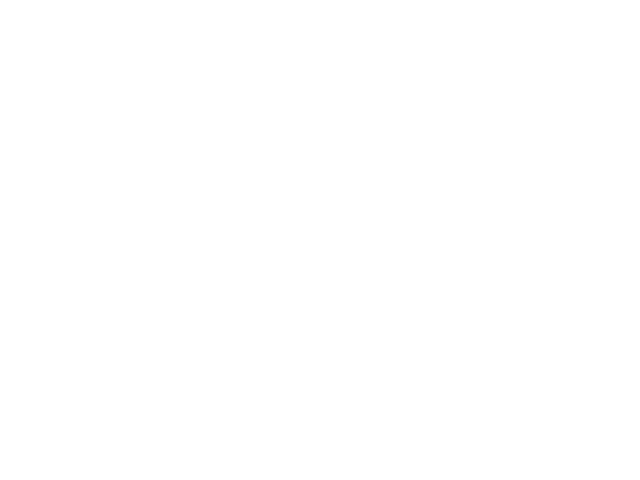

In [14]:
%matplotlib notebook

nPlots = 1
startIndex = 2600


ax = plt.plot(dfPulses[dfPulses.columns[startIndex]])

for i in range(nPlots - 1):
    plt.plot(dfPulses[dfPulses.columns[startIndex + 1 + i]])
    plt.plot()

In [14]:
def singlePulseToArea(singlePulse):
    newPulse = max(singlePulse) - singlePulse
    return sum(newPulse)

In [15]:
dfAreas = pd.DataFrame(columns = ["Cs137"])

In [16]:
dfAreas["Cs137"] = dfPulses.apply(singlePulseToArea, axis = 0)

In [17]:
dfAreas

Cs137
0       16273
1        4309
2        1555
3        1453
4        1437
...       ...
159046  16847
159047   9726
159048   3307
159049   1318
159050   3353

[159051 rows x 1 columns]

In [18]:
dfAreas.to_csv("../PeakDetection_Cs137_Areas_2kV_v4_t100.csv")

In [41]:
dfAreasCalibrated = dfAreas*0.04227 - 25.74
dfAreasCalibrated = dfAreas*0.03671 - 25.74

<IPython.core.display.Javascript object>


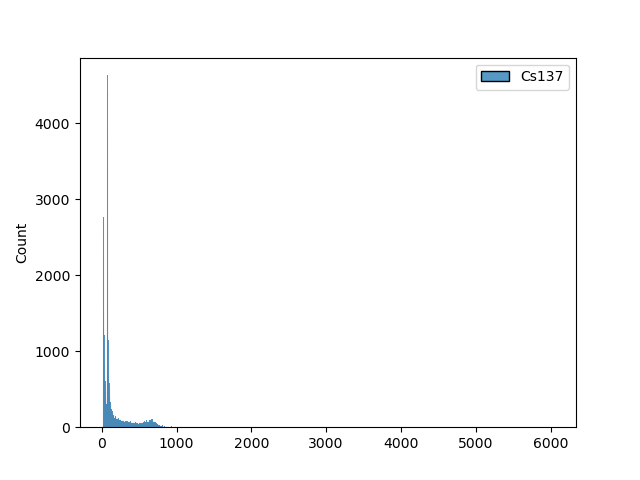

In [42]:
%matplotlib notebook
sns.histplot(dfAreasCalibrated, bins = 5000)
plt.show()

In [18]:
dfAreasCo60 = pd.read_csv("../PeakDetection_Co60_Areas_2kV_v4_t100.csv", index_col = 0)

In [19]:
dfAreasCs137 = pd.read_csv("../PeakDetection_Cs137_Areas_2kV_v4_t100.csv", index_col = 0)

In [20]:
#Make sure there's the same amount of data from each dataset
dfAreasCs137 = dfAreasCs137[:len(dfAreasCo60)]

In [21]:
dfAreasCs137Calibrated = dfAreasCs137*0.04227 - 25.74
dfAreasCo60Calibrated  = dfAreasCo60*0.04227 - 25.74

In [26]:
dfAreasCs137Calibrated = dfAreasCs137Calibrated.loc[dfAreasCs137Calibrated["Cs137"] < 2000]
dfAreasCo60Calibrated = dfAreasCo60Calibrated.loc[dfAreasCo60Calibrated["Co60"] < 2000]

<IPython.core.display.Javascript object>


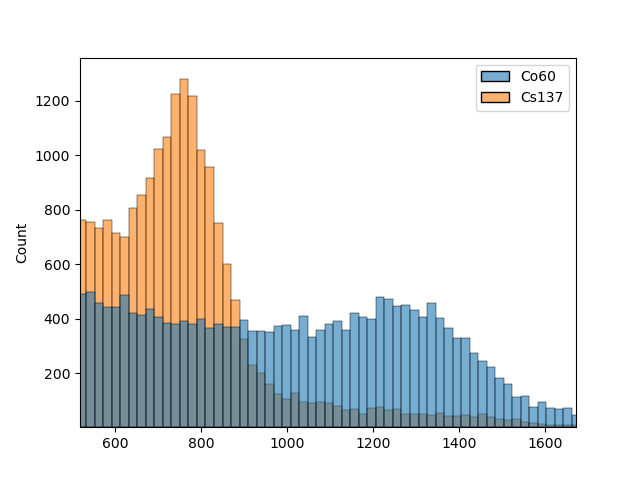

In [30]:
import seaborn as sns
import matplotlib

%matplotlib notebook

sns.histplot(data = [dfAreasCo60Calibrated["Co60"], dfAreasCs137Calibrated["Cs137"]], alpha = 0.6, bins = 100)


plt.show()